In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision as tv

transform = tv.transforms.ToTensor()
ds = tv.datasets.MNIST(root='./data', train=True, transform=transform)

In [2]:
loader = torch.utils.data.DataLoader(dataset = ds,
                                     batch_size = 128,
                                     shuffle = True)

In [3]:
batch = next(iter(loader))
sample_ims, sample_lbls = batch[0], batch[1]

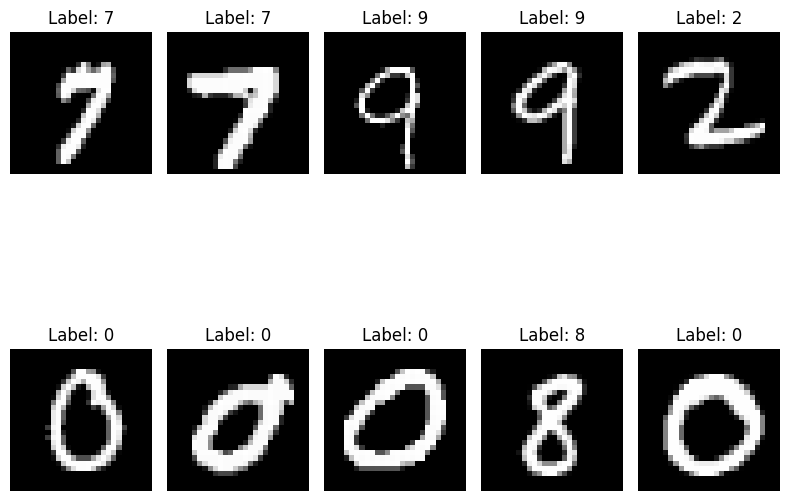

In [4]:
plt.figure(figsize=(8, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_ims[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {sample_lbls[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super().__init__() 
        
        encoder_layers = []
        decoder_layers = []
        current_size = input_size
        
        for hidden_size in hidden_sizes:
            linear_layer = nn.Linear(current_size, hidden_size)
            encoder_layers.append(linear_layer)
            encoder_layers.append(nn.ReLU())
            current_size = hidden_size  
        self.encoder = nn.Sequential(*encoder_layers)

        reversed_hidden_sizes = hidden_sizes[::-1]
        for hidden_size in reversed_hidden_sizes[1:]:
            linear_layer = (nn.Linear(current_size, hidden_size))
            decoder_layers.append(linear_layer)
            decoder_layers.append(nn.ReLU())
            current_size = hidden_size
        decoder_layers.append(nn.Linear(current_size, input_size))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
input_size = 28*28
hidden_sizes = [36, 18, 9]

model = AutoEncoder(input_size, hidden_sizes)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

num_epochs = 20
for epoch in range(num_epochs):
    for data in loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0540
Epoch [6/20], Loss: 0.0396
Epoch [11/20], Loss: 0.0324
Epoch [16/20], Loss: 0.0333


In [8]:
sample_ims_flattened = sample_ims.view(sample_ims.size(0), -1)
sample_ims_flattened = sample_ims_flattened.to(device)
reconstructed_images = model(sample_ims_flattened)
reconstructed_images = reconstructed_images.cpu().detach().numpy()

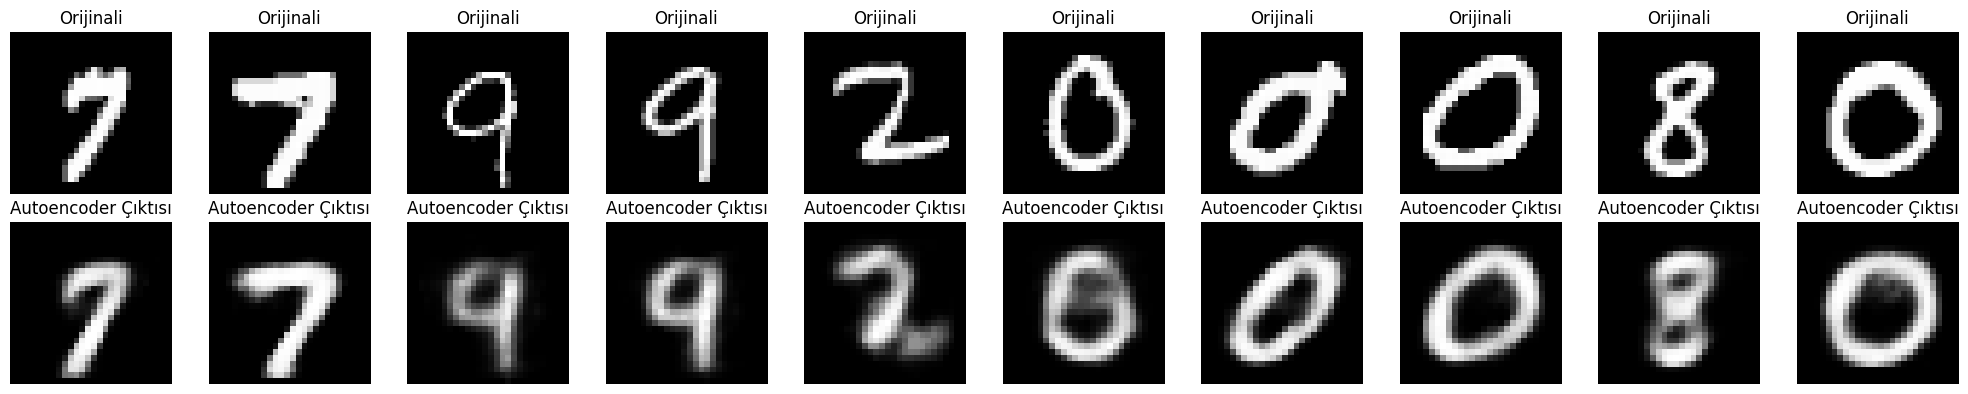

In [9]:
def visualize_images(original, reconstructed, num_images=10):
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[0, i].imshow(original[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title('Orijinali')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title('Autoencoder Çıktısı')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_images(sample_ims.cpu().numpy(), reconstructed_images)